## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [53]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [55]:
# Download MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),                 # Converts image to Tensor [0,1]
    transforms.Normalize((0.5,), (0.5,))   # Normalize grayscale image
])

train_dataset = torchvision.datasets.MNIST(
   root='./data',        # where data is stored
    train=True,           # training set
    download=True,        # download if not present
    transform=transform  # apply transforms
)
test_dataset = torchvision.datasets.MNIST(
     root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

MNIST loaded: 60000 train, 10000 test images


In [56]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes


task_definitions = { #Defining tasks
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}


#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """

     # 1. Collect samples per class
    class_samples = defaultdict(list)

    for img, label in dataset:
        if label in task_classes:
            class_samples[label].append((img, label))

    train_data = []
    support_data = []
    query_data = []

    # 2. Split samples for each class
    for cls in task_classes:
        samples = class_samples[cls]
        random.shuffle(samples)

        train_data.extend(samples[:n_train])
        support_data.extend(samples[n_train:n_train + n_support])
        query_data.extend(samples[n_train + n_support:
                                  n_train + n_support + n_query])

    return train_data, support_data, query_data #Creating datasets as mentioned


# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [57]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [58]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__() #Defining model

        self.conv1 = nn.Conv2d(1, 6, 5) #convolutional layers
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)   # binary classifier

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))  #Forward function for getting output

        # Flatten
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)


        return x





Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [59]:
#First Do normal classification on large dataset of Task A - 0 & 1.

#Task A classes
task_classes = task_definitions['A']  # [0, 1]

# Create train, support, and query sets for Task A
train_data, support_data, query_data = create_task_datasets(
    train_dataset,   # full MNIST train set
    task_classes,

)

# Helper function to make a DataLoader from a list of (image, label) tuples
def to_dataloader(dataset_list, batch_size=32, shuffle=True):
    images = torch.stack([img for img, label in dataset_list])
    labels = torch.tensor([label for img, label in dataset_list], dtype=torch.long)
    tensor_dataset = torch.utils.data.TensorDataset(images, labels)
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)

# Create dataloaders
train_loader = to_dataloader(train_data)
support_loader = to_dataloader(support_data)
query_loader = to_dataloader(query_data)

# Model
model = SimpleNet().to(device)

# Binary classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
loss_history1 = []

for epoch in range(num_epochs): #Loop to learn
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)


    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history1.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "taskA_model.pth")
torch.save(loss_history1, "loss_method1.pth")


Epoch [1/5] - Loss: 0.6910
Epoch [2/5] - Loss: 0.6757
Epoch [3/5] - Loss: 0.6585
Epoch [4/5] - Loss: 0.6394
Epoch [5/5] - Loss: 0.6170


In [67]:
# Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)

# Initializing a new model
model2 = SimpleNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0005)

num_finetune_epochs = 5
loss_history2 = []


for epoch in range(num_finetune_epochs):
    model2.train()
    running_loss = 0.0
    for images, labels in support_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(support_loader.dataset)
    loss_history2.append(epoch_loss)
    print(f"[Fine-Tuning] Epoch [{epoch+1}/{num_finetune_epochs}] - Loss: {epoch_loss:.4f}")

# Save the fine tuned model
torch.save(model2.state_dict(), "taskA_finetuned.pth")
torch.save(loss_history2, "loss_method2.pth")





#Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
# Task B classes
task_classes_B = task_definitions['B']  # [2,3]

# Create train, support, query sets for Task B
train_data_B, support_data_B, query_data_B = create_task_datasets(
    train_dataset, task_classes_B,
)

def remap_labels(dataset_list, task_classes):
    """
    Maps the task_classes to 0,1
    For example, [2,3] -> 0,1
    """
    mapped_list = []
    class_to_idx = {cls: i for i, cls in enumerate(task_classes)}
    for img, label in dataset_list:
        mapped_list.append((img, class_to_idx[label]))
    return mapped_list

#Task B labels
train_data_B = remap_labels(train_data_B, task_classes_B)
support_data_B = remap_labels(support_data_B, task_classes_B)
query_data_B = remap_labels(query_data_B, task_classes_B)




print(f"Task B dataset sizes -> train: {len(train_data_B)}, support: {len(support_data_B)}, query: {len(query_data_B)}")

train_loader_B = to_dataloader(train_data_B, batch_size=32)
support_loader_B = to_dataloader(support_data_B, batch_size=32)
query_loader_B = to_dataloader(query_data_B, batch_size=32)

# Initialize new model
model_B = SimpleNet().to(device)

# Load Task A fine-tuned weights
model_B.load_state_dict(torch.load("/content/taskA_finetuned.pth", map_location=device))
model_B.train()  # set model to training mode

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_B.parameters(), lr=0.0005)

loss_history3 = [] #For saving epoch loss for future use

num_finetune_epochs = 5
for epoch in range(num_finetune_epochs):
    running_loss = 0.0
    for images, labels in support_loader_B:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_B(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(support_loader_B.dataset)
    loss_history3.append(epoch_loss)
    print(f"[Task B Fine Tuning] Epoch [{epoch+1}/{num_finetune_epochs}] Loss: {epoch_loss:.4f}")

torch.save(model_B.state_dict(), "taskB_finetuned.pth")
torch.save(loss_history3, "loss_method3.pth")


[Fine-Tuning] Epoch [1/5] - Loss: 0.6866
[Fine-Tuning] Epoch [2/5] - Loss: 0.6408
[Fine-Tuning] Epoch [3/5] - Loss: 0.5473
[Fine-Tuning] Epoch [4/5] - Loss: 0.3845
[Fine-Tuning] Epoch [5/5] - Loss: 0.1850
Task B dataset sizes -> train: 30, support: 10, query: 20
[Task B Fine Tuning] Epoch [1/5] Loss: 0.8969
[Task B Fine Tuning] Epoch [2/5] Loss: 0.8202
[Task B Fine Tuning] Epoch [3/5] Loss: 0.7723
[Task B Fine Tuning] Epoch [4/5] Loss: 0.7192
[Task B Fine Tuning] Epoch [5/5] Loss: 0.6670


In [68]:
#First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

full_train_loader = DataLoader(
    train_dataset,  # already downloaded MNIST train_dataset
    batch_size=64,  # can adjust as needed
    shuffle=True    # shuffle each epoch
)


# Model for 10 class pretraining
model3 = SimpleNet().to(device)
model3.fc3 = nn.Linear(84, 10).to(device)  # 10 class outputs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

# Use full_train_loader (all MNIST)
num_pretrain_epochs = 5
loss_history4 = []

for epoch in range(num_pretrain_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in full_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(full_train_loader.dataset)
    loss_history4.append(epoch_loss)

    print(f"[Pretrain] Epoch {epoch+1}/{num_pretrain_epochs} - Loss: {running_loss/len(full_train_loader.dataset):.4f}")

# Saving pretraining weights
torch.save(model3.state_dict(), "full_mnist_pretrained.pth")
torch.save(loss_history4, "loss_method4.pth")



#First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.
# Map last FC layer to binary
model3.fc3 = nn.Linear(84, 2).to(device)

# Reload pretrained weights for all layers except last FC
pretrained_dict = torch.load("/content/full_mnist_pretrained.pth", map_location=device)
model_dict = model3.state_dict()

# Only load weights that match in size
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
model_dict.update(pretrained_dict)
model3.load_state_dict(model_dict)


# Create Task A datasets
task_classes = task_definitions['A']  # [0,1]
train_data, support_data, query_data = create_task_datasets(train_dataset, task_classes, n_train=0, n_support=50, n_query=20)

# Map labels to 0,1
def remap_labels(dataset_list, task_classes):
    class_to_idx = {cls: i for i, cls in enumerate(task_classes)}
    return [(img, class_to_idx[label]) for img, label in dataset_list]

support_data = remap_labels(support_data, task_classes)
query_data = remap_labels(query_data, task_classes)

# Dataloaders
support_loader = to_dataloader(support_data, batch_size=16)
query_loader = to_dataloader(query_data, batch_size=16)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0005)   #Taking weights from last model trained on whole data
num_epochs = 5
loss_history5 = []

for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    for images, labels in support_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(support_loader.dataset)
    loss_history5.append(epoch_loss)

    print(f"[Binary Fine-Tuning] Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(support_loader.dataset):.4f}")

torch.save(model3.state_dict(), "taskA_binary_finetuned.pth")
torch.save(loss_history5, "loss_method5.pth")



[Pretrain] Epoch 1/5 - Loss: 0.2613
[Pretrain] Epoch 2/5 - Loss: 0.0800
[Pretrain] Epoch 3/5 - Loss: 0.0584
[Pretrain] Epoch 4/5 - Loss: 0.0445
[Pretrain] Epoch 5/5 - Loss: 0.0364
[Binary Fine-Tuning] Epoch [1/5] Loss: 0.5671
[Binary Fine-Tuning] Epoch [2/5] Loss: 0.0941
[Binary Fine-Tuning] Epoch [3/5] Loss: 0.0195
[Binary Fine-Tuning] Epoch [4/5] Loss: 0.0052
[Binary Fine-Tuning] Epoch [5/5] Loss: 0.0020


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

In [69]:
# At the end compare performance of all this models and methods using the Query Set.

# Load trained model for Method 1
model_query = SimpleNet().to(device)
model_query.load_state_dict(torch.load("/content/taskA_model.pth", map_location=device))
model_query.eval()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in query_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_query(images)            #Evaluating first method of task A on query set of task A
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("Method 1 – Fully Trained Binary Classifier (Task A)")
print(f"Accuracy  : {accuracy*100:.2f}%")
print(f"Precision : {precision*100:.2f}%")
print(f"Recall    : {recall*100:.2f}%")
print(f"F1-score  : {f1*100:.2f}%")


# Load fine-tuned model
model_query2 = SimpleNet().to(device)
model_query2.load_state_dict(torch.load("/content/taskA_finetuned.pth", map_location=device))
model_query2.eval()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in query_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_query2(images)
        preds = torch.argmax(outputs, dim=1) #Evaluating query data using weights of fine tuned model of task A

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy2  = accuracy_score(y_true, y_pred)
precision2 = precision_score(y_true, y_pred)
recall2    = recall_score(y_true, y_pred)
f1_2       = f1_score(y_true, y_pred)

print("Method 2 – Fine Tuned on Support Set (Task A) using bianry classifier of part A")
print(f"Accuracy  : {accuracy2*100:.2f}%")
print(f"Precision : {precision2*100:.2f}%")
print(f"Recall    : {recall2*100:.2f}%")
print(f"F1-score  : {f1_2*100:.2f}%")

# Load fine-tuned model (Method 2)
model_query3 = SimpleNet().to(device)
model_query3.load_state_dict(torch.load("/content/taskA_binary_finetuned.pth", map_location=device))
model_query3.eval()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in query_loader:
        images, labels = images.to(device), labels.to(device) #At last evaluating using weights of fine tuning model which was developed using  all digits classifier model

        outputs = model_query3(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy3  = accuracy_score(y_true, y_pred)
precision3 = precision_score(y_true, y_pred)
recall3    = recall_score(y_true, y_pred)
f1_3      = f1_score(y_true, y_pred)

print("Method 2 – Fine-Tuned on Support Set (Task A) using 3rd part")
print(f"Accuracy  : {accuracy2*100:.2f}%")
print(f"Precision : {precision2*100:.2f}%")
print(f"Recall    : {recall2*100:.2f}%")
print(f"F1-score  : {f1_2*100:.2f}%")




Method 1 – Fully Trained Binary Classifier (Task A)
Accuracy  : 95.00%
Precision : 100.00%
Recall    : 90.00%
F1-score  : 94.74%
Method 2 – Fine Tuned on Support Set (Task A) using bianry classifier of part A
Accuracy  : 97.50%
Precision : 100.00%
Recall    : 95.00%
F1-score  : 97.44%
Method 2 – Fine-Tuned on Support Set (Task A) using 3rd part
Accuracy  : 97.50%
Precision : 100.00%
Recall    : 95.00%
F1-score  : 97.44%


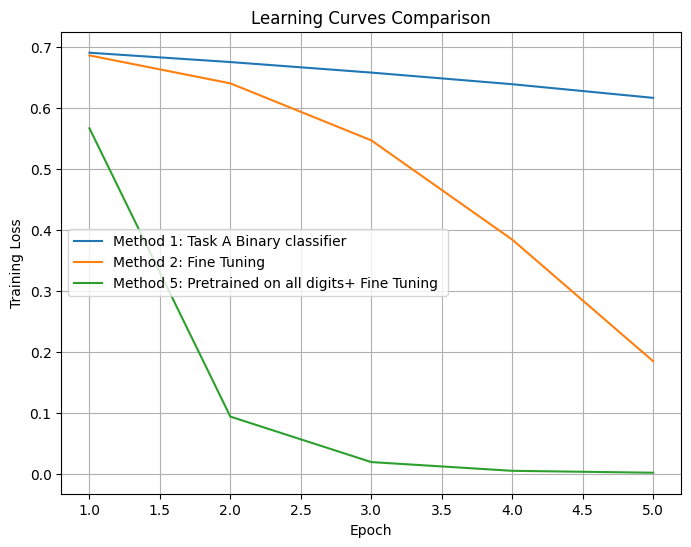

In [70]:
import torch
import matplotlib.pyplot as plt


loss_m1 = torch.load("/content/loss_method1.pth")
loss_m2 = torch.load("/content/loss_method2.pth")
loss_m5 = torch.load("/content/loss_method5.pth")

plt.figure(figsize=(8, 6))

plt.plot(range(1, len(loss_m1)+1), loss_m1, label="Method 1: Task A Binary classifier")
plt.plot(range(1, len(loss_m2)+1), loss_m2, label="Method 2: Fine Tuning")
plt.plot(range(1, len(loss_m5)+1), loss_m5, label="Method 5: Pretrained on all digits+ Fine Tuning ")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Learning Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()



Here we can see that when fine tuning is done using limited data of binary classifier then error is high. But when all digit classifier's weights are used for fine tuning then error is low. Its because pretrained model on all digits learns all features to great extend hence useful for binary task.

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1. I feel that strategy 2, using all digit classifier to fine tune works best as error is less there as visible from the graph.  
This is because the model is trained on a large and diverse dataset during pretraining, which allows it to learn generalizable digit-level features such as edges, curves, and shapes. These learned representations transfer effectively to the binary classification task during fine tuning, resulting in faster convergence and better performance.

2.


3. A model trained only on digits will not work well for letter classification without adaptation.
Digits and letters differ in:  
Shape complexity  
Stroke patterns
Structural features  

A model trained on MNIST digits learns:  
Digit specific patterns  
These features do not fully transfer to letters

Strategy to make it learn :  
Start with the digit trained model and keep early layers  
Train it on a full alphabet dataset  
Replace final layer with binary output  
Fine tune on the binary letter task

4. We have not explicitly used meta learning in any of the approaches.  
All methods implemented are based on transfer learning and fine-tuning.  
Even in the last part, where a digit classifier is fine tuned on a binary task using a support set, the model is not trained across multiple tasks. Therefore, no meta  learning algorithm has been used.



Digit and letter classification are dissimilar tasks with different visual features.  
yes we can have initialisation such that these parameters will give best possible results for  both tasks after fine tuning with a small amount of task specific data.  
By training across a distribution of tasks, it can learn parameters that serve as a good starting point for fine tuning on new tasks, even when tasks are dissimilar.

# ALL THE BEST !